In [1]:
# Cell 1  Paths
from pathlib import Path

ROOT = Path("/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/")
NPZ_SHHS1 = ROOT / "npz_shhs1"
NPZ_SHHS2 = ROOT / "npz_shhs2"
NPZ_MESA = ROOT / "npz_mesa"

print("SHHS1 NPZ:", len(list(NPZ_SHHS1.glob("*.npz"))))
print("SHHS2 NPZ:", len(list(NPZ_SHHS2.glob("*.npz"))))
print("MESA NPZ:", len(list(NPZ_MESA.glob("*.npz"))))

SHHS1 NPZ: 5476
SHHS2 NPZ: 2536
MESA NPZ: 1856


In [2]:
# Cell 2  Inspect one sample
import numpy as np
import pandas as pd

sample = sorted(NPZ_SHHS1.glob("*.npz"))[0]
d = np.load(sample, allow_pickle=True)

print("File:", sample.name)
print("x:", d["x"].shape, d["x"].dtype)
print("y:", d["y"].shape, d["y"].dtype)
print("fs:", int(d["fs"]))
print("channel:", d["channel"])
print("visit:", d["visit"])

print("Label counts:", dict(pd.Series(d["y"]).value_counts().sort_index()))


File: shhs1-200001_v1.npz
x: (1004, 3750) float32
y: (1004,) int64
fs: 125
channel: EEG
visit: v1
Label counts: {0: 264, 1: 45, 2: 448, 3: 145, 4: 102}


In [3]:
# Cell 3  Global stats (table output)

import numpy as np
import pandas as pd

def dataset_stats_row(npz_dir, name):
    n_records = 0
    total_epochs = 0
    tst_hours = []

    for f in npz_dir.glob("*.npz"):
        d = np.load(f, allow_pickle=True)
        y = d["y"]
        n_records += 1
        total_epochs += len(y)
        tst = (np.isin(y, [1,2,3,4]).sum() * 30) / 3600
        tst_hours.append(tst)

    return {
        "Dataset": name,
        "Records": n_records,
        "Total epochs": total_epochs,
        "Mean epochs / record": total_epochs / n_records,
        "Mean TST (h)": float(np.mean(tst_hours)),
        "Median TST (h)": float(np.median(tst_hours)),
    }

stats_df = pd.DataFrame([
    dataset_stats_row(NPZ_SHHS1, "SHHS1"),
    dataset_stats_row(NPZ_SHHS2, "SHHS2"),
    dataset_stats_row(NPZ_MESA, "MESA")
])

stats_df


,Dataset,Records,Total epochs,Mean epochs / record,Mean TST (h),Median TST (h)
0,SHHS1,5476,5116557,934.360299,5.970191,6.025000
1,SHHS2,2536,2859092,1127.402208,6.315615,6.358333
2,MESA,1856,2210701,1191.110453,6.199416,6.191667


In [4]:
# Cell 4  Class distribution table (exclude UNKNOWN / -1)

from collections import Counter
import numpy as np
import pandas as pd

LABELS = {0:"W", 1:"N1", 2:"N2", 3:"N3", 4:"REM"}

def class_distribution_df(npz_dir, dataset_name):
    counter = Counter()

    for f in npz_dir.glob("*.npz"):
        y = np.load(f, allow_pickle=True)["y"]
        y = y[y >= 0]  # exclude UNKNOWN
        counter.update(y.tolist())

    total = sum(counter.values())

    rows = []
    for k in sorted(LABELS.keys()):
        v = counter.get(k, 0)
        rows.append({
            "Dataset": dataset_name,
            "Stage": LABELS[k],
            "Epoch count": v,
            "Fraction": v / total if total > 0 else 0.0
        })

    return pd.DataFrame(rows)

dist_df = pd.concat([
    class_distribution_df(NPZ_SHHS1, "SHHS1"),
    class_distribution_df(NPZ_SHHS2, "SHHS2"),
    class_distribution_df(NPZ_MESA, "MESA"),
], ignore_index=True)

dist_df



,Dataset,Stage,Epoch count,Fraction
0,SHHS1,W,1193349,0.233236
1,SHHS1,N1,199037,0.038901
2,SHHS1,N2,2247695,0.439305
3,SHHS1,N3,701243,0.137056
4,SHHS1,REM,775157,0.151502
5,SHHS2,W,937017,0.327745
6,SHHS2,N1,105618,0.036942
7,SHHS2,N2,1109088,0.387931
8,SHHS2,N3,305231,0.106762
9,SHHS2,REM,402031,0.140620


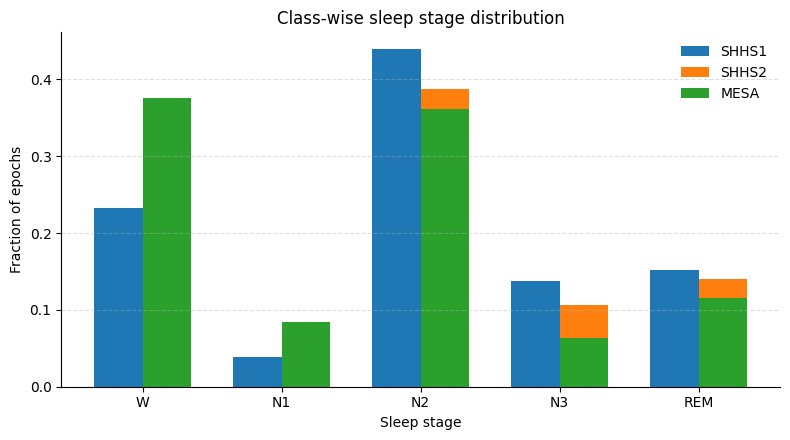

In [5]:
# Cell  Plot class-wise distribution (SHHS1 vs SHHS2)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data (wide format for plotting)
plot_df = dist_df.pivot(index="Stage", columns="Dataset", values="Fraction")
plot_df = plot_df.loc[["W", "N1", "N2", "N3", "REM"]]  # ensure order

# Plot
fig, ax = plt.subplots(figsize=(8, 4.5))

x = np.arange(len(plot_df.index))
width = 0.35

ax.bar(x - width/2, plot_df["SHHS1"], width, label="SHHS1")
ax.bar(x + width/2, plot_df["SHHS2"], width, label="SHHS2")
ax.bar(x + width/2, plot_df["MESA"], width, label="MESA")

# Styling
ax.set_ylabel("Fraction of epochs")
ax.set_xlabel("Sleep stage")
ax.set_title("Class-wise sleep stage distribution")
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index)
ax.legend(frameon=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


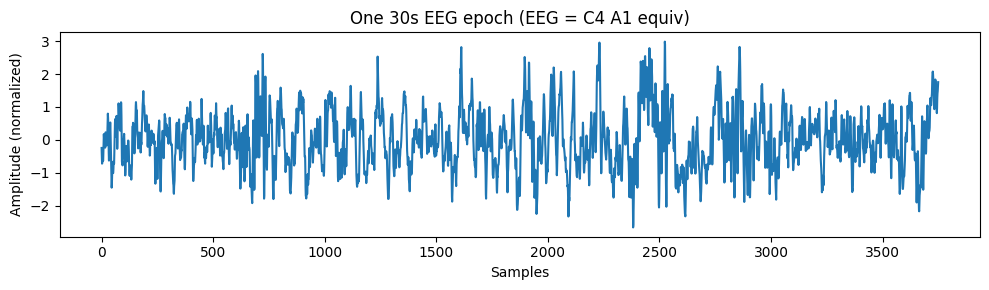

In [6]:
# Cell 5  Plot one EEG epoch
import matplotlib.pyplot as plt

x = d["x"][0]   # first epoch
plt.figure(figsize=(10,3))
plt.plot(x)
plt.title("One 30s EEG epoch (EEG = C4 A1 equiv)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (normalized)")
plt.tight_layout()
plt.show()


In [7]:
# Cell: Unified manifest with subject-wise split (SHHS1) + external eval (SHHS2 + MESA)

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

SEED = 42

# Paths (already verified)
ROOT = Path("/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/")
NPZ_SHHS1 = ROOT / "npz_shhs1"
NPZ_SHHS2 = ROOT / "npz_shhs2"
NPZ_MESA  = ROOT / "npz_mesa"

# -----------------------------
# Helpers
# -----------------------------
def infer_rec_id_from_npz(stem: str, cohort: str) -> str:
    """
    Try to extract a stable subject/record id from filename stem.
    Adjust rules if your naming differs.
    """
    s = stem
    if cohort == "SHHS1":
        s = s.replace("_v1", "")
    elif cohort == "SHHS2":
        s = s.replace("_v2", "")
    # for MESA we usually keep stem as-is (or strip common suffixes if needed)
    # add more replaces here if your mesa files have suffixes like _mesa, _v1, etc.
    return s

def collect_npz_rows(npz_dir: Path, cohort: str, split: str = None):
    rows = []
    for p in sorted(npz_dir.glob("*.npz")):
        rec_id = infer_rec_id_from_npz(p.stem, cohort)
        row = {
            "rec_id": rec_id,
            "npz_path": str(p),
            "cohort": cohort,
        }
        if split is not None:
            row["split"] = split
        rows.append(row)
    return pd.DataFrame(rows)

# -----------------------------
# 1) Collect SHHS1 records
# -----------------------------
df_shhs1 = collect_npz_rows(NPZ_SHHS1, cohort="SHHS1", split=None)
print("SHHS1 records:", len(df_shhs1))

# -----------------------------
# 2) Subject-wise random split (SHHS1 only)
# -----------------------------
subjects = df_shhs1["rec_id"].unique()

train_subj, temp_subj = train_test_split(
    subjects, test_size=0.2, random_state=SEED
)
val_subj, test_subj = train_test_split(
    temp_subj, test_size=0.5, random_state=SEED
)

train_set = set(train_subj)
val_set   = set(val_subj)
test_set  = set(test_subj)

def assign_split(rec_id):
    if rec_id in train_set:
        return "train"
    if rec_id in val_set:
        return "val"
    if rec_id in test_set:
        return "test"
    raise ValueError(f"Unknown subject: {rec_id}")

df_shhs1["split"] = df_shhs1["rec_id"].apply(assign_split)

# -----------------------------
# 3) Collect SHHS2 (external test)
# -----------------------------
df_shhs2 = collect_npz_rows(NPZ_SHHS2, cohort="SHHS2", split="external_test")
print("SHHS2 records:", len(df_shhs2))

# -----------------------------
# 4) Collect MESA (external test)
# -----------------------------
df_mesa = collect_npz_rows(NPZ_MESA, cohort="MESA", split="external_test")
print("MESA records:", len(df_mesa))

# -----------------------------
# 5) Unified manifest
# -----------------------------
manifest = pd.concat([df_shhs1, df_shhs2, df_mesa], ignore_index=True)

# -----------------------------
# 6) Sanity checks (NO leakage)
# -----------------------------
print("\nSplit counts:")
print(manifest.groupby(["cohort", "split"]).size())

# SHHS1 must have train/val/test
assert set(manifest.loc[manifest["cohort"] == "SHHS1", "split"]) == {"train", "val", "test"}

# SHHS2 + MESA must be external_test only
assert (manifest.loc[manifest["cohort"] == "SHHS2", "split"] == "external_test").all()
assert (manifest.loc[manifest["cohort"] == "MESA",  "split"] == "external_test").all()

# Optional: ensure no subject overlap between SHHS1 and eval cohorts (usually different IDs anyway)
shhs1_ids = set(manifest.loc[manifest["cohort"] == "SHHS1", "rec_id"].astype(str))
shhs2_ids = set(manifest.loc[manifest["cohort"] == "SHHS2", "rec_id"].astype(str))
mesa_ids  = set(manifest.loc[manifest["cohort"] == "MESA",  "rec_id"].astype(str))
overlap = shhs1_ids & (shhs2_ids | mesa_ids)
print("\nID overlap SHHS1 vs (SHHS2|MESA):", len(overlap))
# assert len(overlap) == 0  # uncomment if you want to enforce strictly

# -----------------------------
# 7) Save manifest (single source of truth)
# -----------------------------
manifest_path = ROOT / "manifest_sleepstaging_planA.csv"
manifest.to_csv(manifest_path, index=False)

print("\nSaved unified manifest to:")
print(manifest_path)

# quick preview
print("\nHead:")
display(manifest.head())



SHHS1 records: 5476
SHHS2 records: 2536
MESA records: 1856

Split counts:
cohort  split        
MESA    external_test    1856
SHHS1   test              548
        train            4380
        val               548
SHHS2   external_test    2536
dtype: int64

ID overlap SHHS1 vs (SHHS2|MESA): 0

Saved unified manifest to:
/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/manifest_sleepstaging_planA.csv

Head:


,rec_id,npz_path,cohort,split
0,shhs1-200001,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,SHHS1,train
1,shhs1-200003,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,SHHS1,train
2,shhs1-200004,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,SHHS1,train
3,shhs1-200005,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,SHHS1,train
4,shhs1-200006,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,SHHS1,train


In [8]:
# Cell  Load manifest + quick path sanity
import pandas as pd
from pathlib import Path

MANIFEST_PATH = Path("/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/manifest_sleepstaging_planA.csv")
manifest = pd.read_csv(MANIFEST_PATH)

print("Rows:", len(manifest))
print(manifest.groupby(["cohort","split"]).size())

# quick check a few files exist
missing = []
for p in manifest["npz_path"].head(50):
    if not Path(p).exists():
        missing.append(p)
print("Missing (first 50 checked):", len(missing))


Rows: 8012
cohort  split        
SHHS1   test              548
        train            4380
        val               548
SHHS2   external_test    2536
dtype: int64
Missing (first 50 checked): 0


In [1]:
#### from here on we built and rorgnize menifesation for shhs2 subgroups  analsysis 

In [4]:
# =========================
# SERVER CELL 1: Rebind SHHS2 MASTER manifest -> server npz paths
# =========================
import pandas as pd
from pathlib import Path
import re

# -------- EDIT THESE 3 PATHS --------
NPZ_DIR = Path("/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/npz_shhs2/")  # folder containing *.npz (e.g., shhs2-200077_v2.npz)
MASTER_MANIFEST_LOCAL = Path("/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/shhs2_subgroup_manifest.csv")  # upload/copy your local master CSV here
OUT_MASTER_MANIFEST = Path("shhs2_subgroup_manifest_server.csv")
# -----------------------------------

assert NPZ_DIR.exists(), f"Missing NPZ_DIR: {NPZ_DIR}"
assert MASTER_MANIFEST_LOCAL.exists(), f"Missing master manifest: {MASTER_MANIFEST_LOCAL}"

df = pd.read_csv(MASTER_MANIFEST_LOCAL)

print("Loaded master rows:", len(df))
print("NPZ files on server:", len(list(NPZ_DIR.glob('*.npz'))))

# SHHS2 filenames look like: shhs2-200077_v2.npz  -> nsrrid=200077
def extract_nsrrid_from_npz(name: str):
    m = re.search(r"shhs2-(\d+)_v\d+\.npz$", name.lower())
    return int(m.group(1)) if m else None

lookup = {}
bad = 0
for p in NPZ_DIR.glob("*.npz"):
    sid = extract_nsrrid_from_npz(p.name)
    if sid is None:
        bad += 1
        continue
    lookup[sid] = str(p)

print("Lookup size:", len(lookup), "| bad filenames:", bad)

# Rebind npz_path by nsrrid
if "nsrrid" not in df.columns:
    raise ValueError("Master manifest must contain 'nsrrid'.")

df["npz_path"] = df["nsrrid"].map(lookup)
df["npz_exists"] = df["npz_path"].notna()

print("Rebind result:")
print(df["npz_exists"].value_counts(dropna=False))

# Keep only NPZ-backed rows (this should match your processed count)
df2 = df[df["npz_exists"]].copy()
df2.drop(columns=["npz_exists"], inplace=True)

df2.to_csv(OUT_MASTER_MANIFEST, index=False)
print(f"\n? Saved server master manifest: {OUT_MASTER_MANIFEST} | rows={len(df2)}")

# Preview
display(df2.head(10))


Loaded master rows: 2536
NPZ files on server: 2536
Lookup size: 2536 | bad filenames: 0
Rebind result:
True    2536
Name: npz_exists, dtype: int64

? Saved server master manifest: shhs2_subgroup_manifest_server.csv | rows=2536


,nsrrid,npz_path,sex,age_group,bmi_group,ahi_severity,hypertension,diabetes,ahi,nsrr_bp_systolic,nsrr_bp_diastolic,pm220a1,insuln2,dataset
0,200077,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Male,Adult,Normal,Mild,NaN,Diabetes,9.74,NaN,NaN,128.0,0.0,SHHS2
1,200078,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Male,Adult,Obese,Moderate,NaN,Non-diabetes,19.69,NaN,NaN,120.0,0.0,SHHS2
2,200079,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Adult,Obese,Moderate,NaN,Diabetes,26.00,NaN,NaN,128.0,0.0,SHHS2
3,200080,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Male,Adult,Obese,Mild,NaN,Non-diabetes,12.45,NaN,NaN,124.0,0.0,SHHS2
4,200081,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Adult,Obese,No OSA,NaN,Non-diabetes,2.63,NaN,NaN,106.0,0.0,SHHS2
5,200082,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Male,Adult,Overweight,No OSA,NaN,Diabetes,2.84,NaN,NaN,126.0,0.0,SHHS2
6,200088,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Male,Adult,Overweight,No OSA,NaN,Non-diabetes,3.91,NaN,NaN,114.0,0.0,SHHS2
7,200089,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Adult,Normal,Mild,NaN,Non-diabetes,6.89,NaN,NaN,106.0,0.0,SHHS2
8,200091,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Senior,Normal,Mild,NaN,Diabetes,7.41,NaN,NaN,138.0,0.0,SHHS2
9,200092,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Male,Adult,Overweight,Mild,NaN,Diabetes,13.73,NaN,NaN,126.0,0.0,SHHS2


In [6]:
# =========================
# SERVER CELL 2: Rebind ALL SHHS2 subgroup CSVs in a folder -> server paths
# =========================
import pandas as pd
from pathlib import Path

# -------- EDIT THESE 3 PATHS --------
MASTER_SERVER = Path("shhs2_subgroup_manifest_server.csv")   # output from Cell 1
SUBGROUP_DIR_LOCAL = Path("/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/subgroups_shhs2/")                 # folder containing subgroup CSVs (upload/copy it)
OUT_SUBGROUP_DIR = Path("subgroups_shhs2_server")            # will be created
# -----------------------------------

assert MASTER_SERVER.exists(), f"Missing: {MASTER_SERVER}"
assert SUBGROUP_DIR_LOCAL.exists(), f"Missing subgroup folder: {SUBGROUP_DIR_LOCAL}"

OUT_SUBGROUP_DIR.mkdir(parents=True, exist_ok=True)

master = pd.read_csv(MASTER_SERVER)
master = master[["nsrrid", "npz_path"]].copy()

csvs = sorted(SUBGROUP_DIR_LOCAL.glob("*.csv"))
print("Subgroup CSV files found:", len(csvs))

saved = []
for f in csvs:
    sub = pd.read_csv(f)

    if "nsrrid" not in sub.columns:
        print("?? Skipping (no nsrrid):", f.name)
        continue

    # remove old path if any
    sub = sub.drop(columns=["npz_path"], errors="ignore")

    # merge server npz_path
    sub2 = sub.merge(master, on="nsrrid", how="left")

    missing = int(sub2["npz_path"].isna().sum())
    if missing > 0:
        print(f"?? {f.name}: missing npz_path for {missing} rows (will keep, but check IDs)")

    out = OUT_SUBGROUP_DIR / f.name
    sub2.to_csv(out, index=False)
    saved.append((f.name, len(sub2), missing, str(out)))

saved_df = pd.DataFrame(saved, columns=["file", "rows", "missing_npz_path", "saved_to"])
print("\n? Saved rebound subgroup CSVs:", len(saved_df))
display(saved_df)


Subgroup CSV files found: 14

? Saved rebound subgroup CSVs: 14


,file,rows,missing_npz_path,saved_to
0,shhs2_age_group_adult.csv,1063,0,subgroups_shhs2_server/shhs2_age_group_adult.csv
1,shhs2_age_group_senior.csv,1473,0,subgroups_shhs2_server/shhs2_age_group_senior.csv
2,shhs2_ahi_severity_mild.csv,922,0,subgroups_shhs2_server/shhs2_ahi_severity_mild...
3,shhs2_ahi_severity_moderate.csv,614,0,subgroups_shhs2_server/shhs2_ahi_severity_mode...
4,shhs2_ahi_severity_no_osa.csv,605,0,subgroups_shhs2_server/shhs2_ahi_severity_no_o...
5,shhs2_ahi_severity_severe.csv,395,0,subgroups_shhs2_server/shhs2_ahi_severity_seve...
6,shhs2_bmi_group_normal.csv,649,0,subgroups_shhs2_server/shhs2_bmi_group_normal.csv
7,shhs2_bmi_group_obese.csv,807,0,subgroups_shhs2_server/shhs2_bmi_group_obese.csv
8,shhs2_bmi_group_overweight.csv,1059,0,subgroups_shhs2_server/shhs2_bmi_group_overwei...
9,shhs2_diabetes_diabetes.csv,1375,0,subgroups_shhs2_server/shhs2_diabetes_diabetes...


In [9]:
# =========================
# SERVER CELL 1: Rebind MESA MASTER manifest -> server npz paths
# =========================

import pandas as pd
from pathlib import Path
import re

# -------- EDIT THESE 3 PATHS --------
NPZ_DIR = Path("/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/npz_mesa/")  # folder containing MESA *.npz
MASTER_MANIFEST_LOCAL = Path("/data2/Akbar1/sleep_stages_Dibatic/mesa_sleepstaging_planA/manifests/mesa_subgroup_manifest.csv")  # your master MESA manifest (local-generated)
OUT_MASTER_MANIFEST = Path("mesa_subgroup_manifest_server.csv")
# -----------------------------------

assert NPZ_DIR.exists(), f"Missing NPZ_DIR: {NPZ_DIR}"
assert MASTER_MANIFEST_LOCAL.exists(), f"Missing master manifest: {MASTER_MANIFEST_LOCAL}"

df = pd.read_csv(MASTER_MANIFEST_LOCAL)

print("Loaded master rows:", len(df))
npz_files = list(NPZ_DIR.glob("*.npz"))
print("NPZ files on server:", len(npz_files))

def extract_ints(name: str):
    return [int(x) for x in re.findall(r"\d+", name)]

lookup = {}
for p in npz_files:
    for x in extract_ints(p.name):
        lookup[x] = str(p)

print("Lookup size:", len(lookup))

# prefer nsrrid (works for you previously), fallback to mesaid
if "nsrrid" in df.columns:
    df["npz_path"] = df["nsrrid"].map(lookup)
else:
    raise ValueError("Master MESA manifest must contain 'nsrrid'")

df["npz_exists"] = df["npz_path"].notna()

print("Rebind result:")
print(df["npz_exists"].value_counts(dropna=False))

df2 = df[df["npz_exists"]].copy()
df2.drop(columns=["npz_exists"], inplace=True)

df2.to_csv(OUT_MASTER_MANIFEST, index=False)
print(f"\n? Saved server master manifest: {OUT_MASTER_MANIFEST} | rows={len(df2)}")

display(df2.head(10))


Loaded master rows: 1856
NPZ files on server: 1856
Lookup size: 1856
Rebind result:
True    1856
Name: npz_exists, dtype: int64

? Saved server master manifest: mesa_subgroup_manifest_server.csv | rows=1856


,nsrrid,mesaid,npz_path,sex,age_group,bmi_group,ahi_severity,hypertension,ahi,avdnbp5,avdrbp5,dataset
0,1,1,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Senior,Normal,Moderate,Normotensive,18.14,3.0,4.0,MESA
1,2,2,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Senior,Normal,Mild,NaN,8.34,3.0,NaN,MESA
2,6,6,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Adult,Obese,Severe,Normotensive,62.51,4.0,11.0,MESA
3,12,12,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Male,Senior,Overweight,Moderate,NaN,27.47,4.0,NaN,MESA
4,14,14,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Adult,Obese,Mild,Normotensive,11.37,3.0,5.0,MESA
5,16,16,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Adult,Normal,No OSA,NaN,2.70,2.0,NaN,MESA
6,21,21,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Senior,Normal,Moderate,NaN,19.28,3.0,NaN,MESA
7,27,27,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Senior,Normal,Mild,Normotensive,10.00,3.0,3.0,MESA
8,28,28,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Female,Adult,Obese,Moderate,Normotensive,21.87,2.0,7.0,MESA
9,33,33,/data2/Akbar1/sleep_stages_Dibatic/shhs_sleeps...,Male,Senior,Overweight,Severe,NaN,70.48,3.0,NaN,MESA


In [10]:
# =========================
# SERVER CELL 2: Rebind ALL MESA subgroup CSVs in a folder -> server paths
# =========================

import pandas as pd
from pathlib import Path

# -------- EDIT THESE 3 PATHS --------
MASTER_SERVER = Path("mesa_subgroup_manifest_server.csv")     # output from Cell 1
SUBGROUP_DIR_LOCAL = Path("/data2/Akbar1/sleep_stages_Dibatic/mesa_sleepstaging_planA/manifests/subgroups_mesa/")          # your subgroup folder (local-generated)
OUT_SUBGROUP_DIR = Path("subgroups_mesa_server")               # will be created
# -----------------------------------

assert MASTER_SERVER.exists(), f"Missing: {MASTER_SERVER}"
assert SUBGROUP_DIR_LOCAL.exists(), f"Missing subgroup folder: {SUBGROUP_DIR_LOCAL}"

OUT_SUBGROUP_DIR.mkdir(parents=True, exist_ok=True)

master = pd.read_csv(MASTER_SERVER)[["nsrrid", "npz_path"]].copy()

csvs = sorted(SUBGROUP_DIR_LOCAL.glob("*.csv"))
print("Subgroup CSV files found:", len(csvs))

saved = []
for f in csvs:
    sub = pd.read_csv(f)

    if "nsrrid" not in sub.columns:
        print("?? Skipping (no nsrrid):", f.name)
        continue

    sub = sub.drop(columns=["npz_path"], errors="ignore")
    sub2 = sub.merge(master, on="nsrrid", how="left")

    missing = int(sub2["npz_path"].isna().sum())
    if missing > 0:
        print(f"?? {f.name}: missing npz_path for {missing} rows")

    out = OUT_SUBGROUP_DIR / f.name
    sub2.to_csv(out, index=False)
    saved.append((f.name, len(sub2), missing, str(out)))

saved_df = pd.DataFrame(saved, columns=["file", "rows", "missing_npz_path", "saved_to"])
print("\n? Saved rebound subgroup CSVs:", len(saved_df))
display(saved_df)


Subgroup CSV files found: 13

? Saved rebound subgroup CSVs: 13


,file,rows,missing_npz_path,saved_to
0,mesa_age_group_adult.csv,700,0,subgroups_mesa_server/mesa_age_group_adult.csv
1,mesa_age_group_senior.csv,1156,0,subgroups_mesa_server/mesa_age_group_senior.csv
2,mesa_ahi_severity_mild.csv,600,0,subgroups_mesa_server/mesa_ahi_severity_mild.csv
3,mesa_ahi_severity_moderate.csv,473,0,subgroups_mesa_server/mesa_ahi_severity_modera...
4,mesa_ahi_severity_no_osa.csv,375,0,subgroups_mesa_server/mesa_ahi_severity_no_osa...
5,mesa_ahi_severity_severe.csv,408,0,subgroups_mesa_server/mesa_ahi_severity_severe...
6,mesa_bmi_group_normal.csv,509,0,subgroups_mesa_server/mesa_bmi_group_normal.csv
7,mesa_bmi_group_obese.csv,641,0,subgroups_mesa_server/mesa_bmi_group_obese.csv
8,mesa_bmi_group_overweight.csv,702,0,subgroups_mesa_server/mesa_bmi_group_overweigh...
9,mesa_hypertension_normotensive.csv,1142,0,subgroups_mesa_server/mesa_hypertension_normot...
